In [1]:
from pathlib import Path

import numpy as np
import scipy.sparse as sp
import torch
from torch.optim import Adam, Adagrad, Optimizer
from tqdm import trange
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
from triton.profiler import activate

from src.recommender_model import RecommenderModel
from src.utils import train_model, write_submission, plot_losses, evaluate_model

# Matrix Factorization
This notebook provides implementations for Matrix Factorization using a simple Mean-Squared Error loss.

Machine Learning can be used to learn the users and items embeddings. The simplest method uses Mean Squared Error loss to optimize the users and items embeddings.

In [6]:
class MFModel(nn.Module):
	def __init__(self, num_users: int, num_items: int, embedding_dim: int, dropout: float, activation = nn.ReLU()):
		super(MFModel, self).__init__()

		self.num_users = num_users
		self.num_items = num_items
		self.embedding_dim = embedding_dim

		self.users_embeddings = nn.Embedding(num_embeddings=num_users, embedding_dim=embedding_dim)
		self.items_embeddings = nn.Embedding(num_embeddings=num_items, embedding_dim=embedding_dim)

		nn.init.xavier_uniform_(self.users_embeddings.weight)
		nn.init.xavier_uniform_(self.items_embeddings.weight)

		self.dropout = nn.Dropout(dropout)

		# self.fc = nn.Linear(in_features=embedding_dim, out_features=1)
		self.fc = lambda x: torch.sum(x, dim=-1)  # for standard scalar product

		self.activation = activation

	def forward(self, users: torch.tensor, items: torch.tensor) -> torch.tensor:
		user_embeddings = self.dropout(self.users_embeddings(users))
		item_embeddings = self.dropout(self.items_embeddings(items))
		return self.activation(self.fc(user_embeddings * item_embeddings))

In [7]:
class URMDataset(Dataset):
	def __init__(self, urm: sp.csr_matrix):
		self.n: int = urm.nnz

		urm_coo = urm.tocoo()
		self.user_item_coordinates = torch.from_numpy(
			np.vstack((urm_coo.row, urm_coo.col)).T
		)
		self.ratings = torch.from_numpy(
			urm_coo.data
		)

	def __getitem__(self, idx) -> tuple[int, int, float]:
		interaction_coordinates = self.user_item_coordinates[idx]
		return interaction_coordinates[0], interaction_coordinates[1], self.ratings[idx]

	def __len__(self):
		return self.n

In [8]:
class MFMSE(RecommenderModel):
	def __init__(self):
		super(MFMSE, self).__init__()
		self.mf_model: MFModel | None = None
		self.optimizer: Optimizer | None = None
		self.loss_fn = None
		self.best_map = 0.0
		self.checkpoint_dir = Path("model_checkpoints")
		self.checkpoint_dir.mkdir(exist_ok=True)

	def save_checkpoint(self, map_score: float, epoch: int) -> None:
		"""Save model checkpoint if current MAP@10 is better than previous best

		Args:
			map_score: Current MAP@10 score
			epoch: Current epoch number
		"""
		if map_score > self.best_map:
			self.best_map = map_score
			checkpoint = {
				'epoch': epoch,
				'model_state_dict': self.mf_model.state_dict(),
				'optimizer_state_dict': self.optimizer.state_dict(),
				'map_score': map_score,
				'embedding_dim': self.mf_model.embedding_dim,
				'num_users': self.mf_model.num_users,
				'num_items': self.mf_model.num_items,
			}

			checkpoint_path = self.checkpoint_dir / 'best_model.pth'
			torch.save(checkpoint, checkpoint_path)

	def load_best_model(self) -> None:
		"""Load the best performing model"""
		checkpoint_path = self.checkpoint_dir / 'best_model.pth'
		if checkpoint_path.exists():
			checkpoint = torch.load(checkpoint_path)

			# Recreate the model if it doesn't exist
			if self.mf_model is None:
				self.mf_model = MFModel(
					num_users=checkpoint['num_users'],
					num_items=checkpoint['num_items'],
					embedding_dim=checkpoint['embedding_dim'],
					dropout=0.0  # We typically don't need dropout during inference
				)

			self.mf_model.load_state_dict(checkpoint['model_state_dict'])
			if self.optimizer is not None:
				self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

			self.best_map = checkpoint['map_score']
			print(f"Loaded best model with MAP@10: {self.best_map:.5f} from epoch {checkpoint['epoch']}")
		else:
			print("No checkpoint found.")

	def fit(self, urm: sp.csr_matrix, icm: sp.csr_matrix, urm_val: sp.csr_matrix, lr: float = .001, embedding_dim: int = 128, dropout: float = .2, epochs: int = 10, batch_size: int = 8192, weight_decay: float = 1e-4, loss_fn=nn.MSELoss(), activation=nn.ReLU(), plot_loss: bool = True)-> None:
		self.urm = urm
		self.mf_model = MFModel(urm.shape[0], urm.shape[1], embedding_dim, dropout, activation)
		self.optimizer = Adam(self.mf_model.parameters(), lr=lr, weight_decay=weight_decay)
		self.loss_fn = loss_fn

		validation_enabled = urm_val.nnz > 0

		dataloader = DataLoader(
			URMDataset(urm),
			batch_size=batch_size,
			shuffle=True,
			num_workers=8,
		)
		dataloader_val = DataLoader(
			URMDataset(urm_val),
			batch_size=batch_size,
			num_workers=8,
		)
		dl_len = len(dataloader)

		loss_history_val = np.zeros(epochs + 1)
		map_history = np.zeros(epochs + 1)
		loss_history = np.zeros((dl_len * epochs,))

		if validation_enabled:
			self._compute_full_urm_pred()
			map_history[0], loss_history_val[0] = self._validate(dataloader_val, urm_val)
			self.save_checkpoint(map_history[0], 0)

		for epoch in (t := trange(epochs)):
			self.mf_model.train()
			for batch_idx, (users, items, labels) in enumerate(dataloader):
				pred = self.mf_model(
					users,
					items
				).squeeze()
				loss = self.loss_fn(pred, labels)

				self.optimizer.zero_grad()
				loss.backward()
				self.optimizer.step()

				loss_history[dl_len * epoch + batch_idx] = loss.item()
				with torch.no_grad():
					t.set_postfix({
						"Batch progression": f"{(batch_idx + 1) / dl_len * 100:.2f}%",
						"Train loss": f"{loss.item():.5f}",
						"Val loss": f"{loss_history_val[epoch]:.5f}",
						"MAP@10": f"{map_history[epoch]:.5f}",
						"Best MAP@10": f"{self.best_map:.5f}",
						"Pred stats": f"(mean:{pred.mean().item():.4f},std:{pred.std().item():.4f})",
					})
			if validation_enabled:
				self._compute_full_urm_pred()
				map_history[epoch + 1], loss_history_val[epoch + 1] = self._validate(dataloader_val, urm_val)
				self.save_checkpoint(map_history[epoch + 1], epoch + 1)

		if not validation_enabled:
			self._compute_full_urm_pred()  # as it has not been done before
		plot_losses(epochs, loss_history, loss_history_val, len(dataloader), ('MAP@10', [x * len(dataloader) for x in range(epochs + 1)], map_history))

	@torch.no_grad()
	def _compute_full_urm_pred(self, use_linear: bool = False) -> None:
		"""In-place computation of the final predicted URM matrix using the final Linear layer"""
		self.mf_model.eval()
		del self.urm_pred  # free memory

		if use_linear:
			w = self.mf_model.fc.weight
			w_sign = torch.sign(w)
			w_sqrt = torch.sqrt(torch.abs(w))
			b = self.mf_model.fc.bias.item() or 0

			weighted_users_embeddings = self.mf_model.users_embeddings.weight * w_sqrt * w_sign
			weighted_items_embeddings = self.mf_model.items_embeddings.weight * w_sqrt

			self.urm_pred = self.mf_model.activation(
				weighted_users_embeddings @ weighted_items_embeddings.T + b
			).numpy()
		else:
			self.urm_pred = (
				self.mf_model.users_embeddings.weight @ self.mf_model.items_embeddings.weight.T
			).numpy()

	@torch.no_grad()
	def _validate(self, dataloader_val: DataLoader, urm_val: sp.csr_matrix) -> tuple[float, float]:
		"""Returns the MAP@10 and the validation loss"""
		self.mf_model.eval()
		loss = 0
		for users, items, labels in dataloader_val:
			pred = self.mf_model(
				users,
				items
			).squeeze()
			loss += self.loss_fn(pred, labels)

		loss /= len(dataloader_val)
		return evaluate_model(self, urm_val, users_to_test=.1), loss.item()

100%|██████████| 100/100 [25:00<00:00, 15.01s/it, Batch progression=100.00%, Train loss=0.91212, Val loss=0.91738, MAP@10=0.00314, Best MAP@10=0.00414, Pred stats=(mean:0.0493,std:0.0913)]


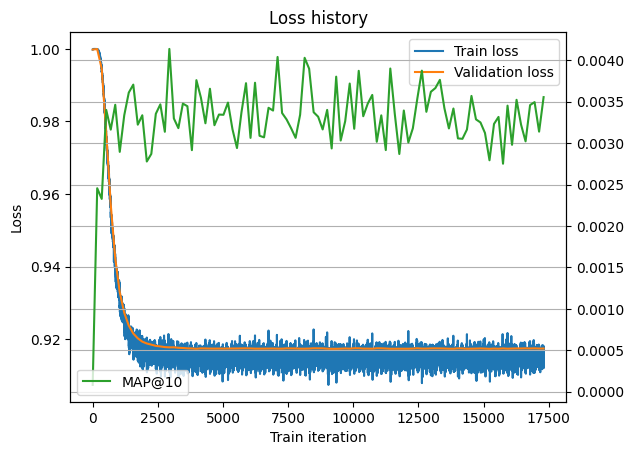

MAP@10 evaluation of the MFMSE model: 0.00358


In [5]:
mfmse_train = train_model(MFMSE(), batch_size=8192, epochs=100, embedding_dim=16, loss_fn=nn.MSELoss(), activation=nn.ReLU())

We see that the MSE loss is not effective and leads to poor performance in terms of MAP@10.

100%|██████████| 15/15 [03:16<00:00, 13.10s/it, Batch progression=100.00%, Train loss=0.91477, Val loss=0.00000, MAP@10=0.00000, Best MAP@10=0.00000, Pred stats=(mean:0.0476,std:0.0873)]


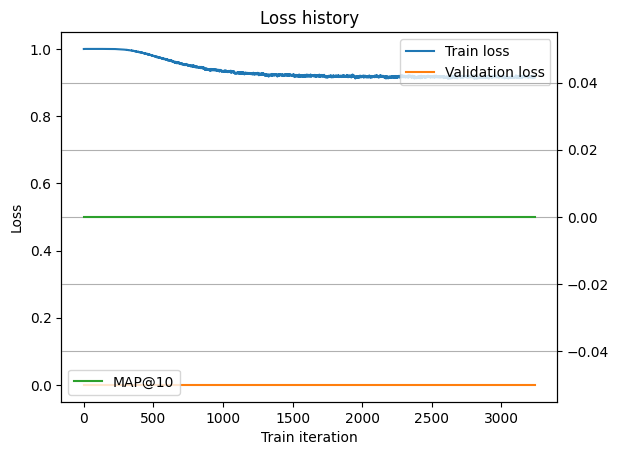

In [9]:
mfmse_submission = train_model(MFMSE(), test_size=0, batch_size=8192, epochs=15, embedding_dim=16, loss_fn=nn.MSELoss(), activation=nn.ReLU())
write_submission(mfmse_submission, "mfmse_submission.csv")